The ModelSounding class allows us to create a vertical sounding through any available AWIPS model with isobaric levels.

* A Shapely Point geometry is used to select longitude and latitude:
        from shapely.geometry import Point
        point = Point(-104.67,39.87)
* Parameters `['T','DpT','uW','vW']` are requested for all isobaric levels available for the selected model.

* There is a single-record query performed for `level = "0.0FHAG"` to determine the surface pressure level.
* Pay attention to units when switching models.  This notebook was written for the NAM 40km AWIPS model where temperature and dewpoint are returned as Kelvin and wind components as m/s.

In [1]:
%matplotlib inline
from awips.dataaccess import DataAccessLayer, ModelSounding
from awips import ThriftClient
import matplotlib.pyplot as plt
import numpy as np
from metpy.plots import SkewT, Hodograph
from metpy.units import units
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from math import sqrt
from datetime import datetime, timedelta
from shapely.geometry import Point, Polygon
import shapely.wkb
import timeit
model="NAM40"
parms = ['T','DpT','uW','vW']
server = 'edex-cloud.unidata.ucar.edu'
DataAccessLayer.changeEDEXHost(server)

# note the order is LON,lat and not lat,LON
point = Point(-104.67,39.87)

inc = 0.005
bbox=[point.y-inc, point.y+inc, point.x-inc, point.x+inc]
polygon = Polygon([(bbox[0],bbox[2]),(bbox[0],bbox[3]), 
                   (bbox[1],bbox[3]),(bbox[1],bbox[2]),
                   (bbox[0],bbox[2])])

# Get latest forecast cycle run
timeReq = DataAccessLayer.newDataRequest("grid")
timeReq.setLocationNames(model)
cycles = DataAccessLayer.getAvailableTimes(timeReq, True)
times = DataAccessLayer.getAvailableTimes(timeReq)
fcstRun = DataAccessLayer.getForecastRun(cycles[-2], times)

print("Using " + model + " forecast time " + str(fcstRun[0]))

Using NAM40 forecast time 2018-10-15 06:00:00


In [2]:
p,t,d,u,v = [],[],[],[],[]
use_parms = ['T','DpT','uW','vW','P']
use_level = "0.0FHAG"
sndObject = ModelSounding.getSounding(model, use_parms, 
                                      ["0.0FHAG"], point, timeRange=[fcstRun[0]])
if len(sndObject) > 0:
    for time in sndObject._dataDict:
        p.append(float(sndObject._dataDict[time][use_level]['P']))
        t.append(float(sndObject._dataDict[time][use_level]['T']))
        d.append(float(sndObject._dataDict[time][use_level]['DpT']))
        u.append(float(sndObject._dataDict[time][use_level]['uW']))
        v.append(float(sndObject._dataDict[time][use_level]['vW']))
    print("Found surface record at " + "%.1f" % p[0] + "MB")
else:
    raise ValueError("sndObject returned empty for query [" 
                    + ', '.join(str(x) for x in (model, use_parms, point, use_level)) +"]")
    


Found surface record at 836.9MB


In [3]:

# Get isobaric levels with our requested parameters
levelReq = DataAccessLayer.newDataRequest("grid", envelope=point)
levelReq.setLocationNames(model)
levelReq.setParameters('T','DpT','uW','vW')
availableLevels = DataAccessLayer.getAvailableLevels(levelReq)

# Clean levels list of unit string (MB, FHAG, etc.)
levels = []
for lvl in availableLevels:
    name=str(lvl)
    if 'MB' in name and '_' not in name:
        # If this level is above (less than in mb) our 0.0FHAG record
        if float(name.replace('MB','')) < p[0]:
            levels.append(lvl)

# Get Sounding
sndObject = ModelSounding.getSounding(model, parms, levels, point, 
                        timeRange=[fcstRun[0]])

if not len(sndObject) > 0:
    raise ValueError("sndObject returned empty for query [" 
                    + ', '.join(str(x) for x in (model, parms, point, levels)) +"]")
    
for time in sndObject._dataDict:
    for lvl in sndObject._dataDict[time].levels():
        for parm in sndObject._dataDict[time][lvl].parameters():
            if parm == "T":
                t.append(float(sndObject._dataDict[time][lvl][parm]))
            elif parm == "DpT":
                d.append(float(sndObject._dataDict[time][lvl][parm]))
            elif parm == 'uW':
                u.append(float(sndObject._dataDict[time][lvl][parm]))
            elif parm == 'vW':
                v.append(float(sndObject._dataDict[time][lvl][parm]))
            else:
                print("WHAT IS THIS")
                print(sndObject._dataDict[time][lvl][parm])
        # Pressure is our requested level rather than a returned parameter
        p.append(float(lvl.replace('MB','')))

# convert to numpy.array()
p = np.array(p, dtype=float)
t = (np.array(t, dtype=float) - 273.15) * units.degC
d = (np.array(d, dtype=float) - 273.15) * units.degC
u = (np.array(u, dtype=float) * units('m/s')).to('knots')
v = (np.array(v, dtype=float) * units('m/s')).to('knots')
w = np.sqrt(u**2 + v**2)

print("Using " + str(len(levels)) + " levels between " + 
      str("%.1f" % max(p)) + " and " + str("%.1f" % min(p)) + "MB")

Using 32 levels between 836.9 and 50.0MB


---

## Skew-T/Log-P

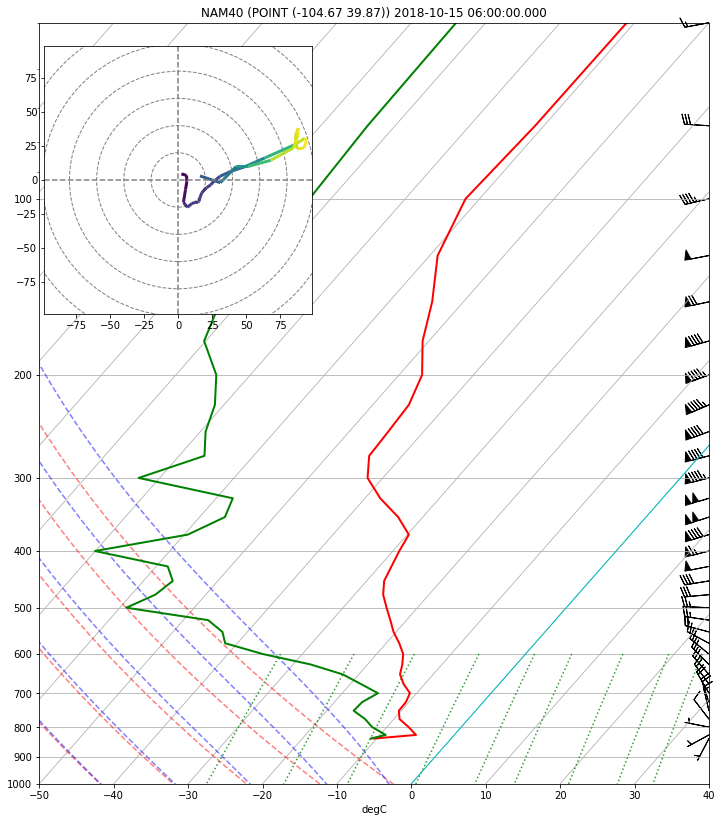

In [4]:
plt.rcParams['figure.figsize'] = (12, 14)

# Skew-T
skew = SkewT(rotation=45)
skew.plot(p, t, 'r', linewidth=2)
skew.plot(p, d, 'g', linewidth=2)
skew.plot_barbs(p, u, v)
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines(linestyle=':')

skew.ax.set_ylim(1000, np.min(p))
skew.ax.set_xlim(-50, 40)

# Title
plt.title( model + " (" + str(point) + ") " + str(time.getRefTime()))

# Hodograph
ax_hod = inset_axes(skew.ax, '40%', '40%', loc=2)
h = Hodograph(ax_hod, component_range=max(w.magnitude))
h.add_grid(increment=20)
h.plot_colormapped(u, v, w)

# Dotted line at 0C isotherm
l = skew.ax.axvline(0, color='c', linestyle='-', linewidth=1)

plt.show()

## Model Sounding Comparison

Using CMC forecast time 2018-10-15 06:00:00
Found surface record at 849.0MB
Using 19 levels between 849.0 and 50.0MB


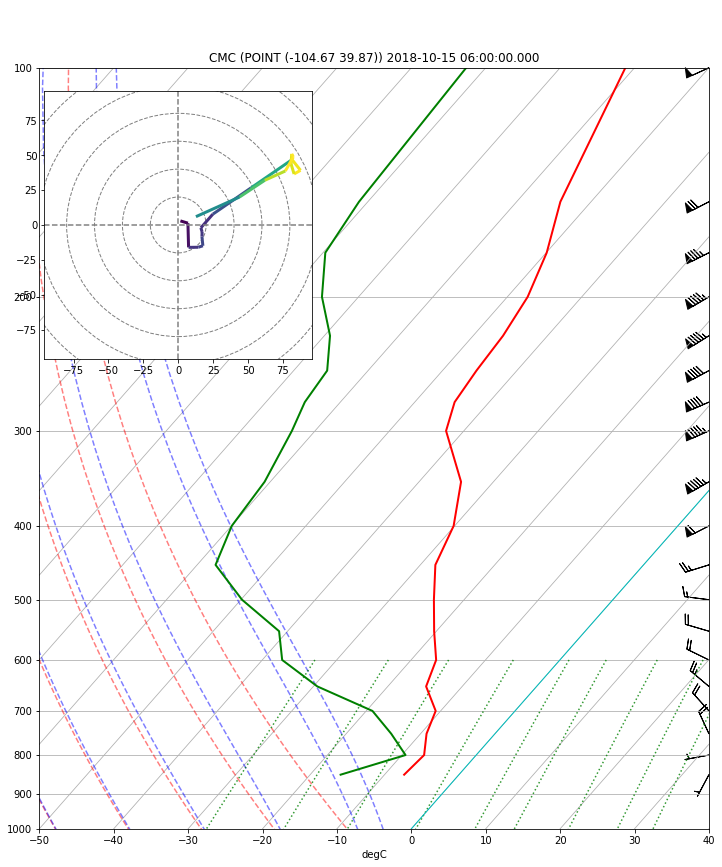

Using GFS20 forecast time 2018-10-15 06:00:00
Found surface record at 848.4MB
Using 22 levels between 848.4 and 100.0MB


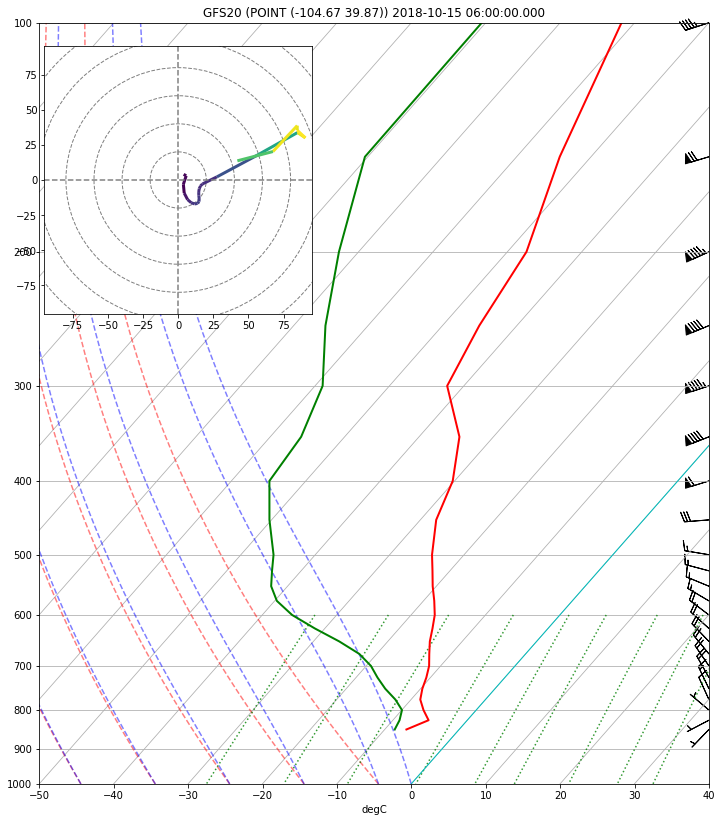

Using NAM40 forecast time 2018-10-15 12:00:00
Found surface record at 836.4MB
Using 32 levels between 836.4 and 50.0MB


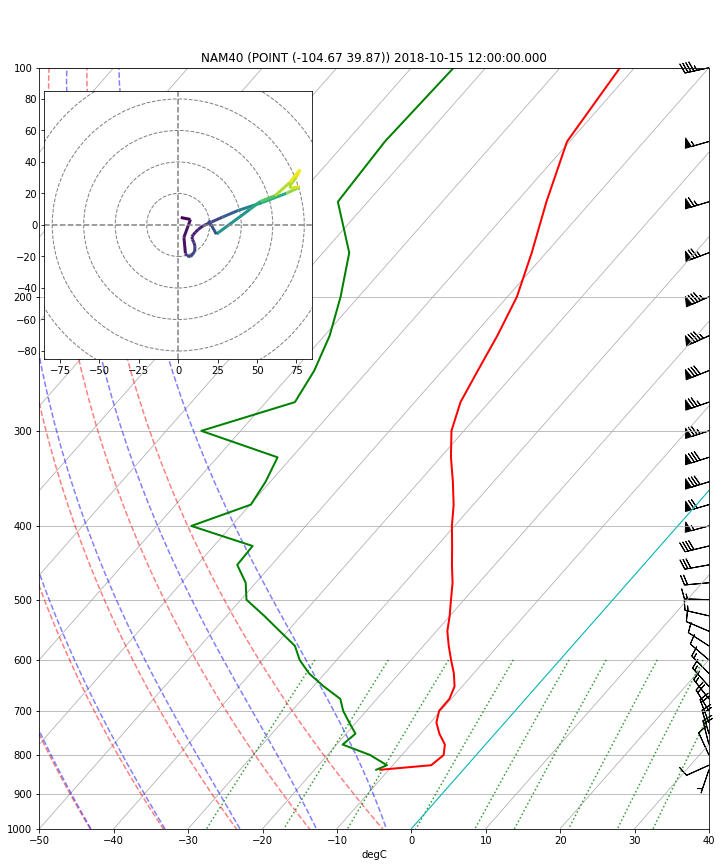

Using RAP13 forecast time 2018-10-15 13:00:00
Found surface record at 843.9MB
Using 30 levels between 843.9 and 100.0MB


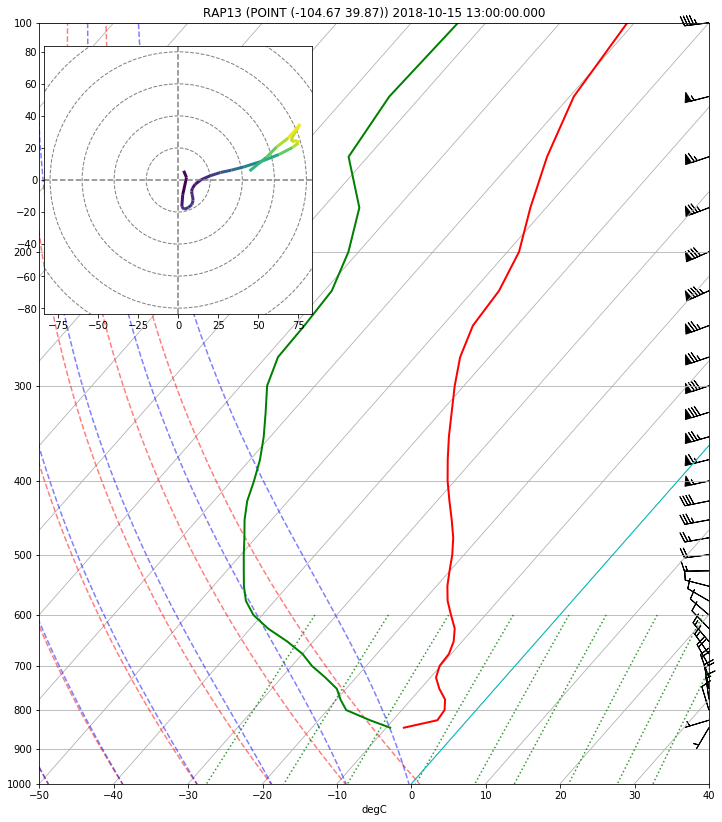

In [6]:
models = ["CMC", "GFS20", "NAM40", "RAP13"]
parms = ['T','DpT','uW','vW']

for modelName in models:
    timeReq = DataAccessLayer.newDataRequest("grid")
    timeReq.setLocationNames(modelName)
    cycles = DataAccessLayer.getAvailableTimes(timeReq, True)
    times = DataAccessLayer.getAvailableTimes(timeReq)
    fcstRun = DataAccessLayer.getForecastRun(cycles[-1], times)
    print("Using " + modelName + " forecast time " + str(fcstRun[0]))
    
    p,t,d,u,v = [],[],[],[],[]
    use_parms = ['T','DpT','uW','vW','P']
    use_level = "0.0FHAG"
    
    sndObject = ModelSounding.getSounding(modelName, use_parms, 
                                          [use_level], point, timeRange=[fcstRun[0]])
    if len(sndObject) > 0:
        for time in sndObject._dataDict:
            p.append(float(sndObject._dataDict[time][use_level]['P']))
            t.append(float(sndObject._dataDict[time][use_level]['T']))
            d.append(float(sndObject._dataDict[time][use_level]['DpT']))
            u.append(float(sndObject._dataDict[time][use_level]['uW']))
            v.append(float(sndObject._dataDict[time][use_level]['vW']))
        print("Found surface record at " + "%.1f" % p[0] + "MB")
    else:
        raise ValueError("sndObject returned empty for query [" 
                        + ', '.join(str(x) for x in (modelName, use_parms, point, use_level)) +"]")
        
    # Get isobaric levels with our requested parameters
    levelReq = DataAccessLayer.newDataRequest("grid", envelope=point)
    levelReq.setLocationNames(modelName)
    levelReq.setParameters('T','DpT','uW','vW')
    availableLevels = DataAccessLayer.getAvailableLevels(levelReq)
    # Clean levels list of unit string (MB, FHAG, etc.)
    levels = []
    for lvl in availableLevels:
        name=str(lvl)
        if 'MB' in name and '_' not in name:
            # If this level is above (less than in mb) our 0.0FHAG record
            if float(name.replace('MB','')) < p[0]:
                levels.append(lvl)
                
    # Get Sounding
    sndObject = ModelSounding.getSounding(modelName, parms, levels, point, 
                            timeRange=[fcstRun[0]])
    if not len(sndObject) > 0:
        raise ValueError("sndObject returned empty for query [" 
                        + ', '.join(str(x) for x in (modelName, parms, point, levels)) +"]")
    for time in sndObject._dataDict:
        for lvl in sndObject._dataDict[time].levels():
            for parm in sndObject._dataDict[time][lvl].parameters():
                if parm == "T":
                    t.append(float(sndObject._dataDict[time][lvl][parm]))
                elif parm == "DpT":
                    d.append(float(sndObject._dataDict[time][lvl][parm]))
                elif parm == 'uW':
                    u.append(float(sndObject._dataDict[time][lvl][parm]))
                elif parm == 'vW':
                    v.append(float(sndObject._dataDict[time][lvl][parm]))
                else:
                    print("WHAT IS THIS")
                    print(sndObject._dataDict[time][lvl][parm])
            # Pressure is our requested level rather than a returned parameter
            p.append(float(lvl.replace('MB','')))

    # convert to numpy.array()
    p = np.array(p, dtype=float)
    t = (np.array(t, dtype=float) - 273.15) * units.degC
    d = (np.array(d, dtype=float) - 273.15) * units.degC
    u = (np.array(u, dtype=float) * units('m/s')).to('knots')
    v = (np.array(v, dtype=float) * units('m/s')).to('knots')
    w = np.sqrt(u**2 + v**2)

    print("Using " + str(len(levels)) + " levels between " + 
          str("%.1f" % max(p)) + " and " + str("%.1f" % min(p)) + "MB")

    # Skew-T
    plt.rcParams['figure.figsize'] = (12, 14)
    skew = SkewT(rotation=45)
    skew.plot(p, t, 'r', linewidth=2)
    skew.plot(p, d, 'g', linewidth=2)
    skew.plot_barbs(p, u, v)
    skew.plot_dry_adiabats()
    skew.plot_moist_adiabats()
    skew.plot_mixing_lines(linestyle=':')
    skew.ax.set_ylim(1000, 100)
    skew.ax.set_xlim(-50, 40)
    # Title
    plt.title( modelName + " (" + str(point) + ") " + str(time.getRefTime()))
    # Hodograph
    ax_hod = inset_axes(skew.ax, '40%', '40%', loc=2)
    h = Hodograph(ax_hod, component_range=max(w.magnitude))
    h.add_grid(increment=20)
    h.plot_colormapped(u, v, w)
    # Dotted line at 0C isotherm
    l = skew.ax.axvline(0, color='c', linestyle='-', linewidth=1)
    plt.show()